In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

from utils.wrangle import wrangle


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('data/commodity_prices.csv')
df = wrangle(df)

df.describe(include='all')

,Product_Type,Arrival_Date,Market,Is_VFPCK,Season,Modal_Price,Max_Price,Min_Price
count,97646,97646,97646,97646,97646,97646.000000,97646.000000,97646.000000
unique,114,NaN,28,2,4,NaN,NaN,NaN
top,Banana|Nendra Bale|Large,NaN,North Paravur,False,Southwest Monsoon,NaN,NaN,NaN
freq,3814,NaN,13064,80553,41551,NaN,NaN,NaN
mean,NaN,2025-01-06 19:41:31.604367104,NaN,NaN,NaN,5361.754419,6021.509033,4775.422176
min,NaN,2024-06-02 00:00:00,NaN,NaN,NaN,300.000000,0.000000,0.000000
25%,NaN,2024-09-23 00:00:00,NaN,NaN,NaN,3000.000000,3500.000000,2500.000000
50%,NaN,2025-01-15 00:00:00,NaN,NaN,NaN,4500.000000,5000.000000,4000.000000
75%,NaN,2025-04-24 00:00:00,NaN,NaN,NaN,6000.000000,6500.000000,5500.000000
max,NaN,2025-08-04 00:00:00,NaN,NaN,NaN,90000.000000,110000.000000,75000.000000


In [3]:
anova_results = {}

for product_type, group in df.groupby('Product_Type'):
    seasonal_groups = [seasonal_group['Modal_Price'].values for name, seasonal_group in group.groupby('Season')]

    if len(seasonal_groups) >= 2:
        stat, pval = f_oneway(*seasonal_groups)
        anova_results[product_type] = {'F-statistic': stat, 'p-value': pval}

# Convert to DataFrame for sorting/filtering
anova_df = pd.DataFrame(anova_results).T.reset_index().rename(columns={'index': 'Product_Type'})

anova_df = anova_df.sort_values(by='p-value', ascending=True).reset_index(drop=True)
anova_df.head(10)

,Product_Type,F-statistic,p-value
0,Banana - Green|Banana - Green|FAQ,910.842569,0.000000e+00
1,Banana|Nendra Bale|Large,1217.391616,0.000000e+00
2,Onion|Big|FAQ,493.364342,2.991365e-224
3,Ashgourd|Ashgourd|FAQ,407.829913,6.973649e-223
4,Drumstick|Drumstick|FAQ,448.239732,1.190074e-219
5,Ginger(Green)|Green Ginger|FAQ,388.416562,1.819221e-190
6,Banana|Palayamthodan|Large,327.869077,3.214126e-179
7,Green Chilli|Green Chilly|FAQ,293.588116,5.858009e-157
8,Carrot|Carrot|FAQ,281.799611,1.868369e-151
9,Amphophalus|Amphophalus|FAQ,310.315342,1.611693e-142


Most commodities (>90%) show strong seasonal price variation.
High seasonal impact: Banana (Nendra Bale, Green), Ashgourd, Ginger (Green), Bitter Gourd, Drumstick, Onion (Big).
Low/no seasonal effect: Amaranthus, Cowpea (Bean Barbati), Papaya (Raw), Onion (1st Sort Non-FAQ).
Borderline: French Beans, Water Melon, Amaranthus (Other).
Seasonal swings align with crop perishability and harvest timing.

In [4]:
# Boolean flag: at least one record in VFPCK
vfpck_flag = (
    df.groupby('Product_Type')['Is_VFPCK']
      .any()
      .reset_index()
      .rename(columns={'Is_VFPCK': 'Has_VFPCK'})
)

# Fraction of records in VFPCK
vfpck_stats = (
    df.groupby('Product_Type')['Is_VFPCK']
      .mean()
      .reset_index()
      .rename(columns={'Is_VFPCK': 'Pct_VFPCK'})
)

# Merge both into ANOVA table
vfpck_df = anova_df.merge(vfpck_stats, on='Product_Type', how='left')
vfpck_df = vfpck_df.merge(vfpck_flag, on='Product_Type', how='left')

# Keep only products that have VFPCK presence
vfpck_df = vfpck_df[vfpck_df['Has_VFPCK'] == True]

# Sort if needed
vfpck_df = vfpck_df.sort_values('p-value').reset_index(drop=True)

# Display the final DataFrame
vfpck_df.head(10)

,Product_Type,F-statistic,p-value,Pct_VFPCK,Has_VFPCK
0,Banana - Green|Banana - Green|FAQ,910.842569,0.000000e+00,0.260853,True
1,Banana|Nendra Bale|Large,1217.391616,0.000000e+00,0.873361,True
2,Ashgourd|Ashgourd|FAQ,407.829913,6.973649e-223,0.268340,True
3,Ginger(Green)|Green Ginger|FAQ,388.416562,1.819221e-190,0.001829,True
4,Banana|Palayamthodan|Large,327.869077,3.214126e-179,0.862737,True
5,Amphophalus|Amphophalus|FAQ,310.315342,1.611693e-142,0.043651,True
6,Bitter gourd|Bitter Gourd|FAQ,200.957072,1.253015e-115,0.089395,True
7,Ashgourd|Other|FAQ,115.542313,3.425063e-60,0.001499,True
8,Cucumbar(Kheera)|Cucumbar|FAQ,98.238547,4.802033e-60,0.310387,True
9,Tapioca|Tapioca|FAQ,83.512777,2.064807e-51,0.162196,True


“VFPCK’s work has increased market access for farmers, but our analysis shows seasonal price swings remain high — even for commodities where VFPCK has significant market share.
Given the perishability of these crops, full-season storage is unrealistic. Instead, investments in value addition, short-term cold chain, market diversification, and forward contracting could better stabilize farmer incomes.”

In [5]:
model = smf.mixedlm('Modal_Price ~ C(Market) + C(Product_Type)', 
                data=df, 
                groups=df['Arrival_Date'])
result = model.fit()

print(result.summary())

                                           Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       Modal_Price 
No. Observations:                       97646                         Method:                                   REML        
No. Groups:                             429                           Scale:                                    3677490.4347
Min. group size:                        12                            Log-Likelihood:                           -876362.9858
Max. group size:                        315                           Converged:                                Yes         
Mean group size:                        227.6                                                                               
----------------------------------------------------------------------------------------------------------------------------
                                            

**Observation:**  
Mixed-effects model results show clear, consistent price differences between markets, even after controlling for product type and arrival date.  
This suggests that market-level factors (e.g., supply chain, demand patterns, VFPCK vs. non-VFPCK operations) play a significant role in price variation.  
These coefficients provide a baseline-adjusted measure of each market’s typical pricing, which we will use to rank markets by relative price levels.

In [6]:
# Get market ranking
fe_params = result.fe_params
market_ranking = fe_params.filter(like='C(Market)')
market_ranking.index = market_ranking.index.str.replace('C(Market)[T.', '').str.replace(']', '')
market_ranking['Aluva'] = 0  # Add Aluva as baseline
market_ranking.sort_values(ascending=True, inplace=True)
print(market_ranking)

KURUMASSERY VFPCK        -1050.608139
Vengola  VFPCK            -992.694940
Keezhampara VFPCK         -821.120063
Edackattuvayal  VFPCK     -800.982419
Mazhuvannur VFPCK         -684.049859
Perumbavoor               -669.439607
Mookkannur  VFPCK         -626.767868
Thiruvaniyoor  VFPCK      -499.722304
POTHANIKKADU VFPCK        -444.389310
Nedungapra  VFPCK         -442.633896
THURAVOOR VFPCK           -424.226778
KANJOOR VFPCK             -379.610992
Koovapadi VFPCK           -356.616621
KARUMALOOR VFPCK          -305.500836
Moovattupuzha             -304.217218
Amalapuram  VFPCK         -268.321977
Kothamangalam             -184.950669
Kunnukara  VFPCK          -151.990391
Malayattoor  VFPCK         -75.742433
Aluva                        0.000000
Ernakulam                   18.375581
Kadungallur  VFPCK         135.635640
Puthenvelikkara  VFPCK     436.460327
North Paravur              619.026390
Angamaly                   731.975215
Broadway market            788.907226
Piravam     

We observe that most VFPCK markets tend to offer lower prices compared to non-VFPCK markets.  
Earlier seasonal analysis showed that VFPCK prices also fluctuate with seasonality.  
From a consumer’s perspective, these lower prices are beneficial, but for farmers, they may reduce profit margins.  

Higher prices in urban or semi-urban markets like Angamaly and Ernakulam could be driven by stronger demand and higher willingness to pay, possibly amplified by transportation and logistics costs.  
However, to draw a stronger conclusion, we would need to map each market’s location, classify them as urban/rural, and examine their surrounding population and demand patterns.

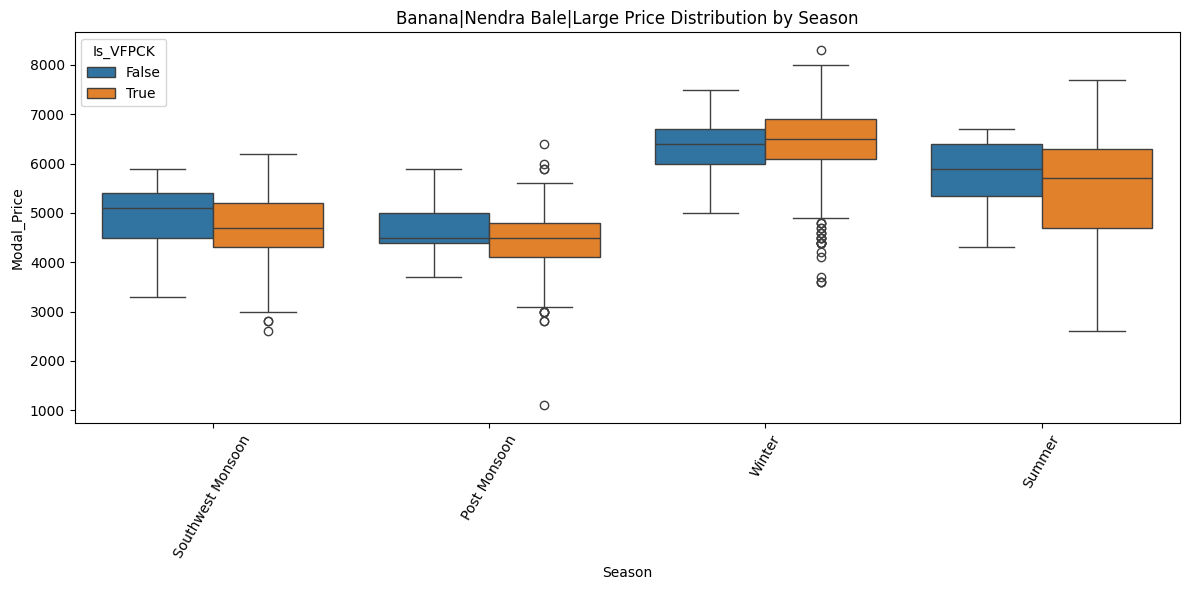

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Banana|Nendra Bale|Large'], x='Season', y='Modal_Price', hue='Is_VFPCK',ax=ax)
ax.set_title('Banana|Nendra Bale|Large Price Distribution by Season')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

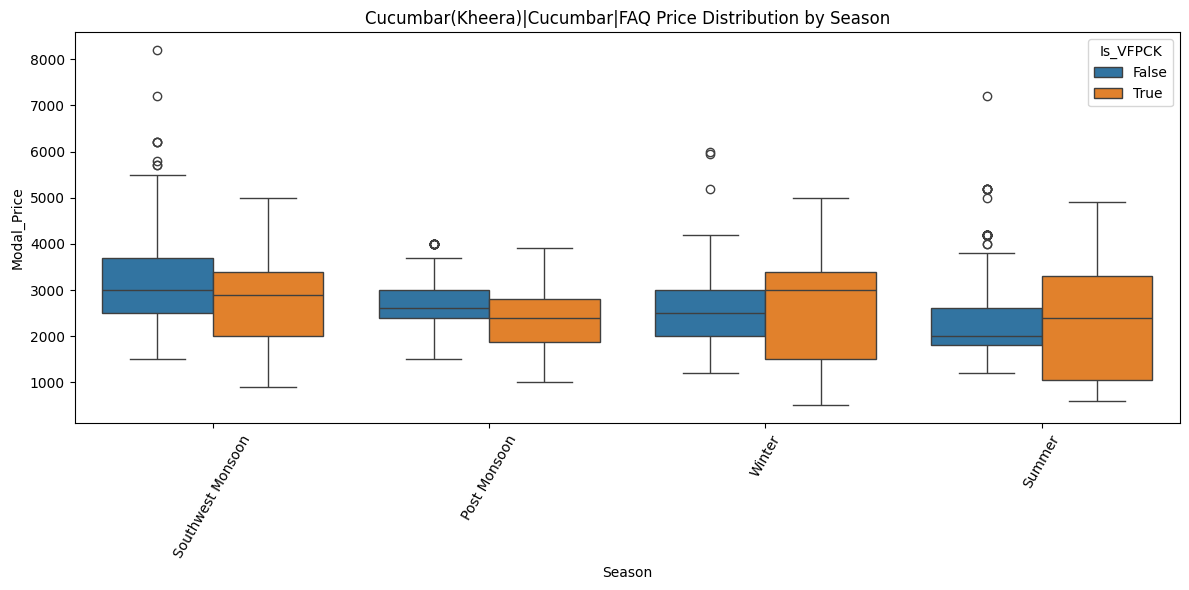

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Cucumbar(Kheera)|Cucumbar|FAQ'], x='Season', y='Modal_Price', hue='Is_VFPCK',ax=ax)
ax.set_title('Cucumbar(Kheera)|Cucumbar|FAQ Price Distribution by Season')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()